# Финальный проект

-------------------------------------------------------

# Import libs

In [137]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
sys.path.append(os.path.abspath('../src/'))

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items, PrefilterItems
from recommenders import ALSRecommendation, OwnRecommendation, PopularItemsRecommendation, BaseRecommender, ClassificationModel, LightGBMRecommendation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import requests

tg_api_token = '5043397400:AAExpKcTarTWA2nYlvB_rOyL7vMVe8e1DFw'
tg_chat_id = '1971178318'

def send_tg_message(text='Cell execution completed.'):
    requests.post(
        'https://api.telegram.org/' +
        'bot{}/sendMessage'.format(tg_api_token), 
        params=dict(chat_id=tg_chat_id, text=text)
    )

## Read data

In [139]:
from pathlib import Path

DATA_PATH = Path('../Data/')
RETAIL_TRAIN_PATH = DATA_PATH / 'retail_train.csv'
ITEM_FEATURE_PATH = DATA_PATH / 'product.csv'
USER_FEATURE_PATH = DATA_PATH / 'hh_demographic.csv'
TEST_DATA = DATA_PATH / 'retail_test1.csv'

data = pd.read_csv(RETAIL_TRAIN_PATH)
item_features = pd.read_csv(ITEM_FEATURE_PATH)
user_features = pd.read_csv(USER_FEATURE_PATH)
test_data = pd.read_csv(TEST_DATA)


In [140]:
train_data = data.copy()

# Process features dataset

In [141]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

**TODO:** подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)

In [142]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель --


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [143]:
# данные со старых покупок до 9 недельной давности. Тренировка для модели первого уровня
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# данные от 9 недельной давности до 3 недельной давности. Тест для модели первого уровня
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели (не более 3 недельной давности)
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [144]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [145]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')
print_stats_data(test_data, 'test_data')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329
test_data
Shape: (88734, 12) Users: 1885 Items: 20497


# Prefilter items

In [146]:
#wrapper for prefilter func

class PrefilterItems:
    def __init__(self, items_data, take_n_popular, warm_start, main_data=None) -> None:
        self.main_data = main_data
        self.items_data = items_data
        self.take_n_popular =take_n_popular
        self.warm_start = warm_start
    
    def __call__(self, *args: 'Any', **kwds: 'Any') -> pd.DataFrame:
        params = {
            'data': self.main_data,
            'items_data': self.items_data,
            'take_n_popular': self.take_n_popular,
            'warm_start': self.warm_start
        }
        
        return prefilter_items(**params)
    

In [147]:
#TODO: подобрать take_n_popular

n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher,
                                     items_data=item_features, 
                                     take_n_popular=5000,
                                     warm_start=True
                                    )

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5000


# Make cold-start to warm-start

In [148]:
# TODO: make cold-start

# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

# warm-start: оставляем только тех пользователей которые есть во всех трех наборах данных
data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (1013530, 13) Users: 1904 Items: 5000
val_matcher
Shape: (162611, 12) Users: 1904 Items: 26640
train_ranker
Shape: (162611, 12) Users: 1904 Items: 26640
val_ranker
Shape: (115539, 12) Users: 1904 Items: 23734


**#TODO**: попробовать другие модели LinearRegression, LightFM

# Get candidates

In [149]:
ACTUAL_COL = 'actual'

def get_validation_data_frame(data_val):
    result_eval_matcher = data_val.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
    return result_eval_matcher


result_eval_matcher = get_validation_data_frame(data_val_matcher)
result_eval_matcher.head(2)


,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [150]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [151]:
# als_params = {'data':data_train_matcher, 'item_features': item_features, 'warm_start':True}

# als_model = ALSRecommendation(**als_params)
# als_model.fit()

# bpr_model = ALSRecommendation(**als_params, use_bpr=True)
# bpr_model.fit()

# own = OwnRecommendation(data_train_matcher, warm_start=True)
# own.fit()

# result: best model it's als_model

In [152]:
#uncoment if need

# from swifter import swifter
# N_PREDICT = 50

# models = {als_model:'als', bpr_model:'bpr'}
# recommend_methods = ['base', 'similar_items', 'similar_user_items']

# result_eval_matcher = get_validation_data_frame(data_val_matcher)

# for model, name in models.items():
#     for recommend_method in recommend_methods:
#         result_eval_matcher[name + '_' + recommend_method] = result_eval_matcher[USER_COL].swifter.apply(lambda x: model.recommend(user=x, N=N_PREDICT, how=recommend_method))

# result_eval_matcher['own'] = result_eval_matcher[USER_COL].swifter.apply(lambda x: own.recommend(user=x, N=N_PREDICT))
# result_eval_matcher.head(2)

In [153]:
# sorted(calc_recall(result_eval_matcher, N_PREDICT), key=lambda x: x[1],reverse=True)

Видно, что лучшая модель из предложеных - als

## Improve first level model

In [154]:
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

space = {
    'n_factors': hp.choice('n_factors', [200, 300, 400]),
    'regularization': hp.uniform('regularization', 0, 0.1),
    'iterations': hp.choice('iterations', [60, 70, 80]),
}

In [155]:
N_PREDICTS = 500

def hyperparametr_tuning(params):
    model = ALSRecommendation(**params,
                              data=data_train_matcher,
                              item_features=item_features,
                              warm_start=True,
                              how='bpr'
                             )

    model.fit()

    result_eval_matcher = get_validation_data_frame(data_val=data_val_matcher)
    result_eval_matcher['als'] = result_eval_matcher.user_id.apply(lambda x: model.recommend(x, N=N_PREDICTS))

    test_precision = list(calc_recall(result_eval_matcher, top_k=500))[0][1]

    return {'loss': -test_precision, 'status': STATUS_OK}

In [156]:
trial = Trials()

# best = fmin(
#     fn=hyperparametr_tuning,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=10,
#     trials=trial
# )

# print(f'Best {best}')
# send_tg_message('I calc hyperparametr for 1 level model. Best params is {}'.format(best))

# result is't 
# als_params = {'data':data_train_matcher, 'item_features': item_features, 'iterations':70, 'n_factors':400, 'regularization':0.018,'warm_start':True}

In [157]:
als_params = {'data':data_train_matcher, 'item_features': item_features, 'iterations':70, 'n_factors':400, 'regularization':0.018,'warm_start':True}
selected_model = ALSRecommendation(**als_params)
selected_model.fit()

## Подбор N_predict

In [ ]:
N_PREDICT = 500

n_predicts = [20, 50, 100, 200, 500]
result_eval_matcher = get_validation_data_frame(data_val_matcher)

result_eval_matcher['als'] = result_eval_matcher[USER_COL].swifter.apply(lambda x: selected_model.recommend(user=x, N=N_PREDICT, how='base'))

recall_at_list = [round(list(calc_recall(result_eval_matcher, n_predict))[0][1], 5) for n_predict in n_predicts]

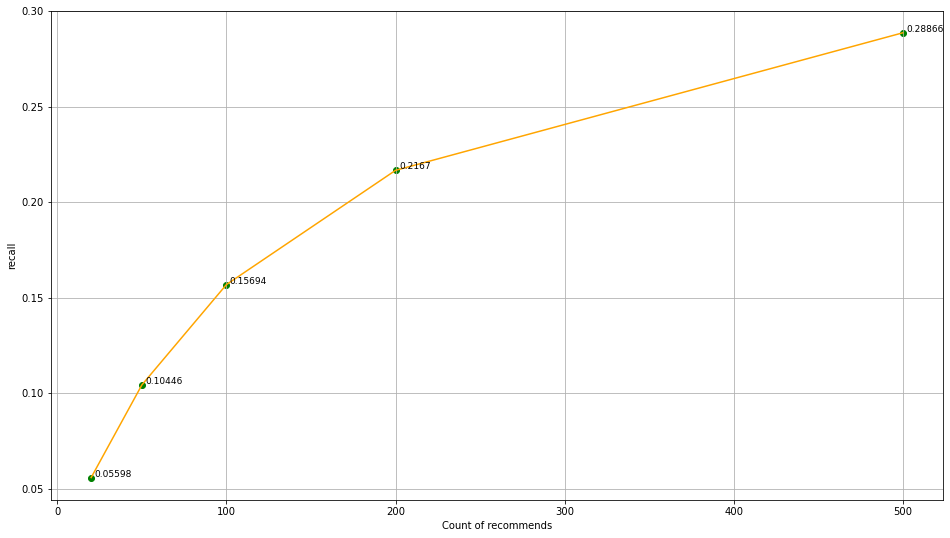

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(n_predicts, recall_at_list, c='orange')
plt.scatter(n_predicts, recall_at_list, c='green')

[plt.text(n_predicts[i] + 2, recall_at_list[i] + .0005, txt, fontsize=9) for i, txt in enumerate(recall_at_list)]

plt.grid()

plt.xlabel('Count of recommends')
plt.ylabel('recall')
plt.show()

# Подготовка данных для трейна

In [159]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]
df_match_candidates.head(2)

,user_id
0,2070
1,2021


In [160]:
# собираем кандитатов с первого этапа (matcher)
N_PREDICT=500

df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: selected_model.recommend(x, N=N_PREDICT))
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[8065410, 897954, 981760, 1000753, 1082185, 85..."
1,2021,"[950935, 1119454, 844179, 1019142, 1000753, 10..."


In [161]:
from recommenders import LightGBMRecommendation

df_ranker_train = LightGBMRecommendation.create_user_item_matrix(df_match_candidates, data_train_ranker)
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,8065410,0.0
1,2070,897954,0.0


## Add new features

In [162]:
# TODO: add other features
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,8065410,0.0
1,2070,897954,0.0


**Фичи user_id:**
   - Средний чек
   - Средняя сумма покупки 1 товара в каждой категории
   - Кол-во покупок в каждой категории
   - Частотность покупок раз/месяц
   - Долю покупок в выходные
   - Долю покупок утром/днем/вечером

**Фичи item_id**:
   - Кол-во покупок в неделю (как часто покупают этот товар)
   - Среднее ол-во покупок 1 товара в категории в неделю (насколько востребована категория)
   - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю) - процент востребованости этого товара в данной категории
   - Цена (Можно посчитать из retil_train.csv)
   - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
   - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
   - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
   - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [163]:
df_ranker_train = LightGBMRecommendation.additional_features(to=df_ranker_train, 
                                                              item_features=item_features,
                                                              user_features=user_features,
                                                              data_train=data_train_ranker)

df_ranker_train.head(2)

,user_id,item_id,target,avg_price_a_department,avg_quantity_week,popular_items_a_week,higher_then_median_price_percent,like_percent_a_department,popular_department,manufacturer,...,SALAD BAR_price,DRUG GM_count,GARDEN CENTER_count,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,8065410,0.0,3.103253,16.833333,16.833333,88.173612,1.250155,1346.500000,397.0,...,0.0,29.0,0.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,897954,0.0,5.267759,12.333333,12.333333,64.450411,1.059868,1163.666667,4303.0,...,0.0,29.0,0.0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


## Fill nan

In [164]:
nun_column_name = df_ranker_train.isna().sum()[df_ranker_train.isna().sum() > 0].index.to_list()

Float columns we going to fill with method knn from sklearn

In [165]:
float_columns = df_ranker_train[nun_column_name].dtypes[df_ranker_train[nun_column_name].dtypes == 'float64'].index.to_list()
float_columns

['avg_price_a_department',
 'avg_quantity_week',
 'popular_items_a_week',
 'higher_then_median_price_percent',
 'like_percent_a_department',
 'popular_department',
 'manufacturer']

Cat columns we going to fill most frequently values 

In [166]:
cat_columns = df_ranker_train[nun_column_name].dtypes[df_ranker_train[nun_column_name].dtypes == 'object'].index.to_list()

In [167]:
from sklearn.impute import SimpleImputer

df_ranker_train_copy = df_ranker_train.copy()


for num_column in float_columns:
    mean = round(df_ranker_train_copy[num_column].median(), 3)
    df_ranker_train_copy[num_column] = df_ranker_train_copy[num_column].fillna(mean)

cat_imputer = SimpleImputer(strategy='most_frequent', add_indicator=True)

def fill_nan(df_ranker_train_copy, imputer, nan_columns):

    columns = df_ranker_train_copy.columns.to_list()
    columns.extend(['is_' + column + '_miss' for column in nan_columns])
    

    df_ranker_train_copy = pd.DataFrame(
        data=imputer.fit_transform(df_ranker_train_copy),
        columns=columns
    )
    return df_ranker_train_copy

df_ranker_train_copy = fill_nan(df_ranker_train_copy, cat_imputer, cat_columns)

df_ranker_train_copy.head(2)

,user_id,item_id,target,avg_price_a_department,avg_quantity_week,popular_items_a_week,higher_then_median_price_percent,like_percent_a_department,popular_department,manufacturer,...,is_commodity_desc_miss,is_sub_commodity_desc_miss,is_curr_size_of_product_miss,is_age_desc_miss,is_marital_status_code_miss,is_income_desc_miss,is_homeowner_desc_miss,is_hh_comp_desc_miss,is_household_size_desc_miss,is_kid_category_desc_miss
0,2070,8065410,0.0,3.103253,16.833333,16.833333,88.173612,1.250155,1346.5,397.0,...,False,False,False,False,False,False,False,False,False,False
1,2070,897954,0.0,5.267759,12.333333,12.333333,64.450411,1.059868,1163.666667,4303.0,...,False,False,False,False,False,False,False,False,False,False


In [168]:
# преобразование в типов в изначальные
num_columns = df_ranker_train.dtypes[~(df_ranker_train.dtypes == 'object')].index.to_list()
for num_col in num_columns:
    df_ranker_train_copy[num_col] = pd.to_numeric(df_ranker_train_copy[num_col])

df_ranker_train_copy.dtypes

user_id                          int64
item_id                          int64
target                         float64
avg_price_a_department         float64
avg_quantity_week              float64
                                ...   
is_income_desc_miss             object
is_homeowner_desc_miss          object
is_hh_comp_desc_miss            object
is_household_size_desc_miss     object
is_kid_category_desc_miss       object
Length: 98, dtype: object

In [169]:
df_ranker_train = df_ranker_train_copy.copy()
df_ranker_train.isna().sum().sum()

0

## Create train data set

In [170]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [171]:
# from utils import reduce_mem_usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

reduce_mem_usage(X_train).head(2)

Memory usage of dataframe is 1631.09 MB
Memory usage after optimization is: 292.47 MB
Decreased by 82.1%


,user_id,item_id,avg_price_a_department,avg_quantity_week,popular_items_a_week,higher_then_median_price_percent,like_percent_a_department,popular_department,manufacturer,department,...,is_commodity_desc_miss,is_sub_commodity_desc_miss,is_curr_size_of_product_miss,is_age_desc_miss,is_marital_status_code_miss,is_income_desc_miss,is_homeowner_desc_miss,is_hh_comp_desc_miss,is_household_size_desc_miss,is_kid_category_desc_miss
0,2070,8065410,3.103253,16.833334,16.833334,88.173615,1.250155,1346.500000,397.0,MEAT-PCKGD,...,False,False,False,False,False,False,False,False,False,False
1,2070,897954,5.267759,12.333333,12.333333,64.450409,1.059868,1163.666626,4303.0,MEAT,...,False,False,False,False,False,False,False,False,False,False



# Select second level model

In [172]:
cat_features = X_train.dtypes[X_train.dtypes == 'category'].index.tolist()
cat_features

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'is_department_miss',
 'is_brand_miss',
 'is_commodity_desc_miss',
 'is_sub_commodity_desc_miss',
 'is_curr_size_of_product_miss',
 'is_age_desc_miss',
 'is_marital_status_code_miss',
 'is_income_desc_miss',
 'is_homeowner_desc_miss',
 'is_hh_comp_desc_miss',
 'is_household_size_desc_miss',
 'is_kid_category_desc_miss']

In [173]:
light_gbm_model = LightGBMRecommendation(categorical_column=cat_features)
light_gbm_model.fit(X_train, y_train.values.ravel())

/Users/janeyaromich/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


## Improve second level model

In [174]:
# [08:52<00:00, 10.66s/trial, best loss: -0.21502100840336139]

best_params = {
    'learning_rate': 0.08, 
    'max_depth': 40, 
    # 'min_child_samples': 3, 
    'min_data_in_leaf': 180, 
    'n_estimators': 30, 
    'num_leaves': 2
}



In [ ]:
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials


space = {
    'max_depth': hp.choice('max_depth', [40, 50, 60, 70]),
#     'num_iterations': hp.choice('num_iterations', [3,1,2,6,4,5,7,8,9,10]),
    'learning_rate': hp.choice('learning_rate', [0.08, 0.08, 0.1]),
    'num_leaves': hp.choice('num_leaves', [2, 4, 5, 10]),
    'n_estimators': hp.choice('n_estimators', [20, 10, 30]),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', [180, 170, 160, 190]),
    # 'min_child_samples': hp.choice('min_child_samples', [32, 35, 30, 25, 27])
}

In [ ]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [ ]:
N_PREDICTS = 5

def hyperparametr_tuning(params):
    model = LightGBMRecommendation(**params,
                                   categorical_column=cat_features,
                                   objective='binary'
#                                     num_threads=4
                                  )

    model.fit(X_train, y_train.values.ravel())

    result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_eval_ranker.columns=[USER_COL, ACTUAL_COL]

    result_eval_ranker['lgbm'] = result_eval_ranker['user_id'].apply(lambda x: model.recommend(x, N=N_PREDICTS))

    test_precision = sorted(calc_precision(result_eval_ranker, N_PREDICTS), key=lambda x: x[1], reverse=True)[0][1]

    return {'loss': -test_precision, 'status': STATUS_OK}

In [ ]:
trial = Trials()

# best = fmin(
#     fn=hyperparametr_tuning,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=trial
# )

# print(f'Best {best}')
# send_tg_message('I calc hyperparametr for 1 level model. Best params is {}'.format(best))

## Fit improved second model

In [175]:
second_model = LightGBMRecommendation(**best_params, categorical_column=cat_features)
second_model.fit(X_train=X_train, y_train=y_train.values.ravel())

/Users/janeyaromich/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180


# Postfiltering

In [185]:
popular_recommendation = PopularItemsRecommendation(warm_start=True)
popular_recommendation.fit(train_data)

,user_id,item_id,quantity
1223029,2337,1120741,234
434552,853,975938,220
775083,1510,1126203,217
774417,1510,894236,215
531201,1023,6533889,214
...,...,...,...
506027,979,917543,1
506028,979,917654,1
506030,979,918335,1
506032,979,918588,1


In [205]:


def postfilter_items(recommendations, N=5):
        """Пост-фильтрация товаров
        
        Input
        -----
        recommendations: list
            Ранжированный список item_id для рекомендаций
        item_info: pd.DataFrame
            Датафрейм с информацией о товарах
        """
        
        # Уникальность
        # recommendations = list(set(recommendations)) - неверно! так теряется порядок
        unique_recommendations = []
        [unique_recommendations.append(item) for item in recommendations if item not in unique_recommendations]
        
        final_recommendations = []
        
        # ! рассширяем по топ полулярными
        if len(unique_recommendations) < N:
            unique_recommendations.extend(self.popular_recommendation.recommend( 
                N=np.abs(len(unique_recommendations) - N) 
            ))
            final_recommendations = unique_recommendations
            print('!')
        else:
            final_recommendations = unique_recommendations[:N]
                
        assert len(final_recommendations) == N, 'Количество рекомендаций != {}'.format(N)
        return final_recommendations
    

# Predict on validation data

In [206]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [207]:
from tqdm import tqdm

tqdm.pandas()

result_eval_ranker['recommendations']  = result_eval_ranker.user_id.progress_apply(
    lambda x: postfilter_items(
        recommendations=second_model.recommend(x, N=50),
        N=5
    ) 
)

result_eval_ranker.head()

100%|██████████| 1904/1904 [00:05<00:00, 360.21it/s]


,user_id,actual,recommendations
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[840361, 995242, 1082185, 995785, 914190]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1029743, 995242, 883404, 862349, 1082185]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1082185, 1058997, 1106523, 1133018, 1126899]"
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1082185, 883404, 1133018, 923746, 1070820]"
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1106523, 1133018, 1029743, 883404, 1126899]"


In [208]:
TOPK_PRECISION = 5

print(sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True))

[('recommendations', 0.24306722689075633)]


# Create a general model to production

In [22]:
cat_features = [
    'department',
    'brand',
    'commodity_desc',
    'sub_commodity_desc',
    'curr_size_of_product',
    'age_desc',
    'marital_status_code',
    'income_desc',
    'homeowner_desc',
    'hh_comp_desc',
    'household_size_desc',
    'kid_category_desc',
    'is_department_miss',
    'is_brand_miss',
    'is_commodity_desc_miss',
    'is_sub_commodity_desc_miss',
    'is_curr_size_of_product_miss',
    'is_age_desc_miss',
    'is_marital_status_code_miss',
    'is_income_desc_miss',
    'is_homeowner_desc_miss',
    'is_hh_comp_desc_miss',
    'is_household_size_desc_miss',
    'is_kid_category_desc_miss'
]

In [133]:
from general_recommenders import GeneralModel

train_data, test_data = GeneralModel.remake_cold_start_to_warm_start(train_data, test_data)

best_params_for_second_models = {
    'learning_rate': 0.08, 
    'max_depth': 40, 
    # 'min_child_samples': 3, 
    'min_data_in_leaf': 180, 
    'n_estimators': 30, 
    'num_leaves': 2
}
input_data = prefilter_items(
                data=train_data,
                items_data=item_features,
                take_n_popular=5000,
                warm_start=True
            )

general_model_params = {
    'first_level_model': ALSRecommendation(
        data=input_data,
        item_features=item_features,
        iterations=70,
        n_factors=400,
        regularization=0.018,
        warm_start=True
    ),
    
    'second_level_model': LightGBMRecommendation(
        categorical_column=cat_features,
        **best_params_for_second_models
    ),
    'item_features': item_features,
    'user_features': user_features
}  

general_model = GeneralModel(**general_model_params)
general_model.fit(input_data)


Memory usage of dataframe is 1921.61 MB
Memory usage after optimization is: 242.33 MB
Decreased by 87.4%


/Users/janeyaromich/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180


# Predict for test

In [134]:
RECOMEND_COUNT = 5

# ! Test data
data = test_data

result = data.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

result = result.merge(
    general_model.recommned(
        users=general_model.get_unique_users(data),
        N=RECOMEND_COUNT
    ),
    on='user_id',
    how='left'
)

TOPK_PRECISION=5

print(sorted(calc_precision(result, TOPK_PRECISION), key=lambda x: x[1], reverse=True))


100%|██████████| 1884/1884 [00:07<00:00, 248.80it/s]


[('recommendation', 0.1383227176220807)]


In [87]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [88]:
TOPK_PRECISION=5

sorted(calc_precision(result, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

/Users/janeyaromich/Documents/ML/RecSys/src/metrics.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


[('recommendation', 0.10485333333333333)]